In [1]:
import torch
import os, sys
import numpy as np
parent_dir = os.path.abspath('../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
os.environ['CUDA_VISIBLE_DEVICES']='0'
from torch.nn.functional import pad,fold
from util.util import kbdwin

In [2]:
a = torch.arange(start=0, end=16,step=1, dtype=torch.float64)
exp = torch.exp(-2j*torch.pi/16*(torch.arange(start=0, end=16//4,step=1, dtype=torch.float64)+1/8))
print(exp)
a = (a[...,:16//2:2]-a[...,1+16//2::2].flip(-1)) - 1j*(a[...,16//2::2]-a[...,1:16//2:2].flip(-1))
print(a)
a = a*exp
a = torch.fft.fft(a)
a = a*exp
print(a)
a = 2/torch.sqrt(torch.tensor(16))*torch.view_as_real(a)
print(a)
a[...,1] = -a[...,1].flip(-1)
a = a.flatten(-2)
print(a)


tensor([0.9988-0.0491j, 0.9040-0.4276j, 0.6716-0.7410j, 0.3369-0.9415j],
       dtype=torch.complex128)
tensor([-15.-1.j, -11.-5.j,  -7.-9.j,  -3.-13.j], dtype=torch.complex128)
tensor([-51.7928+0.0495j,  -1.9844+0.3030j,  -0.5308+0.9604j,  -0.1585+5.6781j],
       dtype=torch.complex128)
tensor([[-2.5896e+01,  2.4742e-02],
        [-9.9219e-01,  1.5152e-01],
        [-2.6542e-01,  4.8018e-01],
        [-7.9249e-02,  2.8391e+00]], dtype=torch.float64)
tensor([-2.5896e+01, -2.8391e+00, -9.9219e-01, -4.8018e-01, -2.6542e-01,
        -1.5152e-01, -7.9249e-02, -2.4742e-02], dtype=torch.float64)


In [3]:
a = torch.arange(start=0, end=16,step=1, dtype=torch.float64)
print(a[...,:16//2:2])
print(a[...,1:16//2:2])
print(a[...,16//2::2])
print(a[...,1+16//2::2])
b = torch.tensor([[1,2,3,4],[5,6,7,8]])
print(b.transpose(-1,-2).flatten(-2))

tensor([0., 2., 4., 6.], dtype=torch.float64)
tensor([1., 3., 5., 7.], dtype=torch.float64)
tensor([ 8., 10., 12., 14.], dtype=torch.float64)
tensor([ 9., 11., 13., 15.], dtype=torch.float64)
tensor([1, 5, 2, 6, 3, 7, 4, 8])


In [43]:
a = torch.arange(start=0, end=16,step=1, dtype=torch.float64)
print(a)
a = a.unfold(-1,2,2)
print(a)
a[...,1] = a[...,1].flip(-1)
print(a)
a = a.unfold(-2,4,4)
print(a)
#a = a[...,0]-a[...,1] + 1j*(a[...,2]-a[...,3])
print(a[0,0,:])


tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.], dtype=torch.float64)
tensor([[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.],
        [ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.]], dtype=torch.float64)
tensor([[ 0., 15.],
        [ 2., 13.],
        [ 4., 11.],
        [ 6.,  9.],
        [ 8.,  7.],
        [10.,  5.],
        [12.,  3.],
        [14.,  1.]], dtype=torch.float64)
tensor([[[ 0.,  2.,  4.,  6.],
         [15., 13., 11.,  9.]],

        [[ 8., 10., 12., 14.],
         [ 7.,  5.,  3.,  1.]]], dtype=torch.float64)
tensor([0., 2., 4., 6.], dtype=torch.float64)


In [4]:
c = torch.stack((torch.arange(start=32//2-1, end=0, step=-2, dtype=torch.long),torch.arange(start=0, end=32//2, step=2, dtype=torch.long)),dim=0)
print(c.shape)
print(c.flatten(-2))

torch.Size([2, 8])
tensor([15, 13, 11,  9,  7,  5,  3,  1,  0,  2,  4,  6,  8, 10, 12, 14])


In [50]:
b = torch.tensor([4,5,6,7])
a = torch.tensor([0,1,2,3])
c = torch.stack((a,b),-1).T.flatten(-2)
d =  torch.stack((c,-c.flip(-1)),dim=-1).flatten(-2)
print(d)

tensor([ 0, -7,  1, -6,  2, -5,  3, -4,  4, -3,  5, -2,  6, -1,  7,  0])


In [6]:
a = torch.arange(start=0, end=16,step=1, dtype=torch.float64)
# a = a.unfold(-1,2,2)
# a.transpose(-1,-2).flatten(-2).roll(8)
# a[...,-1] = a[...,-1].flip(-1)
# a = a.unfold(0,4,4)
print(a.roll(4,dims=-1))

tensor([12., 13., 14., 15.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,
        10., 11.], dtype=torch.float64)


In [7]:
a = torch.tensor([[1,2,3,4],[5,6,7,8]])
a.flatten(-2)

tensor([1, 2, 3, 4, 5, 6, 7, 8])

In [48]:
class FastMDCT4(torch.nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, window=None, center=True, pad_mode='constant', device='cuda') -> None:
        super().__init__()
        self.n_fft = n_fft
        self.pad_mode = pad_mode
        self.device = device
        self.hop_length = hop_length
        self.center = center

        # making window
        if window is None:
            window = torch.ones
        if callable(window):
            self.win_length = int(win_length)
            self.window = window(self.win_length).to(self.device)
        else:
            self.window = window.to(self.device)
            self.win_length = len(window)

        assert self.win_length <= self.n_fft, 'Window lenth %d should be no more than fft length %d'%(self.win_length, self.n_fft)
        assert self.hop_length <= self.win_length, 'You hopped more than one frame'
        
        # 0 2 4 6
        self.idx_1 = torch.arange(
            start=0, end=self.n_fft//2, step=2, dtype=torch.long)
        # 15 13 11 9
        self.idx_2 = torch.arange(
            start=self.n_fft-1, end=self.n_fft//2, step=-2, dtype=torch.long)
        # 8 10 12 14
        self.idx_3 = torch.arange(
            start=self.n_fft//2, end=self.n_fft, step=2, dtype=torch.long)
        # 7 5 3 1
        self.idx_4 = torch.arange(
            start=self.n_fft//2-1, end=0, step=-2, dtype=torch.long)

        self.exp = torch.exp(-2j*torch.pi/self.n_fft*(torch.arange(start=0,
                             end=self.n_fft//4, step=1, dtype=torch.float64)+1/8)).to(self.device)

    def forward(self, signal, return_frames:bool=False):
        # Pad the signal to a proper length
        signal_len = int(len(signal))
        start_pad = 0
        # Pad the signal so that the t-th frame is centered at time t * hop_length. Otherwise, the t-th frame begins at time t * hop_length.
        if self.center:
            start_pad = self.hop_length
        additional_len = signal_len%self.hop_length
        end_pad = start_pad
        if additional_len:
            end_pad = start_pad + self.hop_length - additional_len
        signal = pad(signal, (start_pad,end_pad), mode=self.pad_mode)

        # Slice the signal with overlapping
        signal = signal.unfold(dimension=-1, size=self.win_length, step=self.hop_length)

        # Apply windows to each pieces
        signal = torch.mul(signal.to(self.device), self.window.to(self.device))
        if return_frames:
            frames = signal.clone()
        else:
            frames = torch.empty(1)

        # Pad zeros for DCT
        if self.n_fft > self.win_length:
            signal = pad(signal, (0, self.n_fft-self.win_length), mode='constant')

        # Shift for Time-Domain Aliasing Cancellation (TDAC)
        signal = signal.roll(self.n_fft//4,dims=-1)
        signal[...,0:self.n_fft//4] *= -1

        # Black magik here: fully exploiting the symmetric property of O2FFT,
        # by rearranging the original real sequence into 
        # the real and imag part of a new sequence with half of the length.
        signal = (signal[...,self.idx_1]-signal[...,self.idx_2]) - 1j*(signal[...,self.idx_3]-signal[...,self.idx_4])
        # pre-twiddle
        signal = 0.5*signal.contiguous()*self.exp
        signal = torch.fft.fft(signal,dim=-1)
        # post-twiddle
        signal = 2.0/torch.sqrt(torch.tensor([self.n_fft],device=self.device))*signal*self.exp
        signal = torch.view_as_real(signal)
        # rearranging
        signal[...,1] = -signal[...,1].flip(-1)
        signal = torch.sqrt(torch.tensor([self.n_fft],device=self.device))*signal.flatten(-2)

        return signal, frames

In [51]:
class FastIMDCT4(torch.nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, window=None, center=True, pad_mode='constant', out_length=None,device='cuda') -> None:
        super().__init__()
        self.n_fft = n_fft
        self.pad_mode = pad_mode
        self.device = device
        self.hop_length = hop_length
        self.center = center
        self.out_length = out_length

        # making window
        if window is None:
            window = torch.ones
        if callable(window):
            self.win_length = int(win_length)
            self.window = window(self.win_length).to(self.device)
        else:
            self.window = window.to(self.device)
            self.win_length = len(window)

        assert self.win_length <= self.n_fft, 'Window lenth %d should be no more than fft length %d'%(self.win_length, self.n_fft)
        assert self.hop_length <= self.win_length, 'You hopped more than one frame'
        
        self.exp = torch.exp(-2j*torch.pi/self.n_fft*(torch.arange(start=0,
                             end=self.n_fft//4, step=1, dtype=torch.float64)+1/8)).to(self.device)

    def forward(self, signal, return_frames:bool=False):
        assert signal.dim() == 3, 'Only tensors shaped in BHW are supported, got tensor of shape %s'%(str(signal.size()))
        assert signal.size()[-1] == self.n_fft//2, 'The last dim of input tensor should match the n_fft. Expected %d ,got %d'%(self.n_fft, signal.size()[-1])
        
        signal = signal.to(self.device)
        # Inverse transform at the last dim
        print(signal.shape)
        signal = signal.unfold(-1,2,2)
        signal[...,1] = signal[...,1].flip(-1)
        signal = torch.view_as_complex(signal)

        signal = self.exp*signal
        signal = torch.fft.fft(signal)
        signal = self.exp*signal

        # [0+4j, 1+5j, 2+6j, 3+7j] -> [0,1,2,3,4,5,6,7] 
        signal = torch.view_as_real(signal).T.flatten(-2)
        # [0,1,2,3,4,5,6,7]  -> [[0,-7], [1,-6], ..., [7,0]]
        signal = torch.stack((signal,-signal.flip(-1)),dim=-1)
        # [0, -7,  1, -6,  2, -5,  3, -4,  4, -3,  5, -2,  6, -1,  7,  0]
        # with overlap-add, these redundancy term will be cancelled
        signal = signal.flatten(-2)

        # Shift N/4 for Time-Domain Aliasing Cancellation (TDAC)
        signal[...,0:self.n_fft//4] *= -1
        signal = signal.roll(-self.n_fft//4,dims=-1)

        # Remove padded zeros when doing dct
        if self.n_fft > self.win_length:
            signal = signal[...,:self.win_length]

        # Apply windows to each pieces
        signal = torch.mul(signal, self.window)
        if return_frames:
            frames = signal.clone()
        else:
            frames = torch.zeros(1)

        # Overlapping adding by fold()
        out_len = (signal.size()[-2]-1) * self.hop_length + self.win_length
        signal = fold(signal.transpose_(-1,-2), kernel_size=(1,self.win_length), stride=(1,self.hop_length), output_size=(1,out_len))

        if self.center:
            # extract the middle part
            signal = signal[..., self.win_length//2:-self.win_length//2]
        signal = 4.0*signal / (self.n_fft)
        signal = signal if self.out_length is None else signal[...,:self.out_length]
        return signal, frames

In [10]:
N = 1024
win=kbdwin(N).cuda()
mdct = FastMDCT4(n_fft=N, hop_length=N//2, win_length=N, window=win, center=True, device='cuda')
imdct = FastIMDCT4(n_fft=N, hop_length=N//2, win_length=N, window=win, center=True, device='cuda')

422110
tensor(-2.3373e-05)


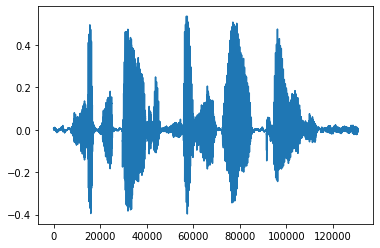

In [11]:
import torchaudio
import matplotlib.pyplot as plt
import torch
import torchaudio.functional as aF
audio_path = '/home/neoncloud/VCTK-Corpus/wav48/p227/p227_003.wav'
metadata = torchaudio.info(audio_path)
print(metadata.num_frames)
audio, fs = torchaudio.load(audio_path)
K = 50000
audio_seg = audio[...,K:130816+K].squeeze()
print(audio_seg.mean())
plt.plot(audio_seg)
plt.show()

torch.Size([257, 512])
cuda:0


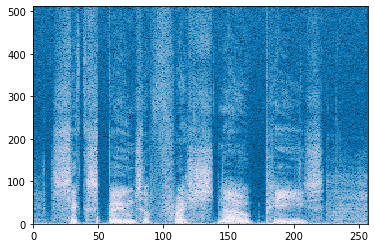

In [12]:
spectro, _ = mdct(audio_seg.cuda().squeeze(0))
spectro_ = aF.amplitude_to_DB((spectro.abs().permute(1,0) + 1e-4),20,1e-4,1).squeeze(0)
print(spectro.size())
print(spectro.device)
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(spectro_.cpu().numpy(), cmap='PuBu_r')
plt.show()

torch.Size([1, 257, 512])
tensor(-2.3327e-05, device='cuda:0', dtype=torch.float64)
tensor(1.3729e-17, dtype=torch.float64)


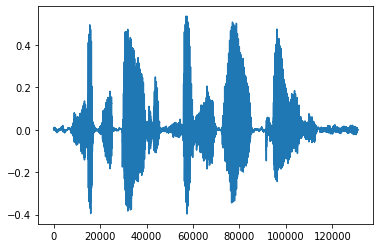

In [13]:
reconstruction, _ = imdct(spectro.unsqueeze(0))
err = (audio_seg.cpu().squeeze()[:130000] - reconstruction.squeeze().cpu()[:130000])**2
print(reconstruction.mean())
print(err.mean())
plt.plot(reconstruction.cpu().squeeze())
plt.show()

In [14]:
from models.mdct import IMDCT4
imdct_ = IMDCT4(n_fft=N, hop_length=N//2, win_length=N, window=win, center=True, device='cuda')

tensor(-3.5006e-05, device='cuda:0', dtype=torch.float64)
tensor(0.0044, dtype=torch.float64)


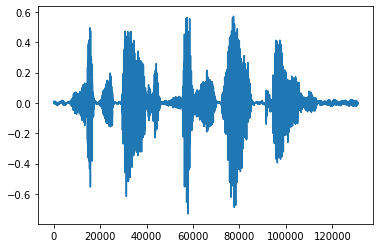

In [15]:
reconstruction_, _ = imdct_(spectro.unsqueeze(0))
err = (audio_seg.cpu().squeeze()[:130000] - reconstruction_.squeeze().cpu()[:130000])**2
print(reconstruction_.mean())
print(err.mean())
plt.plot(reconstruction_.cpu().squeeze())
plt.show()

In [52]:
from time import time
from models.mdct import MDCT4
mdct = MDCT4(n_fft=N, hop_length=N//2, win_length=N, window=win, center=True, device='cuda')
fast_mdct = FastMDCT4(n_fft=N, hop_length=N//2, win_length=N, window=win, center=True, device='cuda')
a = torch.randn(16,1,N//2,N).cuda()

tik = time()
for i in range(200):
    _ = mdct(a)
tok = time()
print("orig:",tok-tik)

tik = time()
for i in range(200):
    _ = fast_mdct(a)
tok = time()
print("fast:",tok-tik)

orig: 0.505314826965332
fast: 3.5760114192962646
